In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import ipywidgets as widgets
import numpy as np
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import utilities as utils
import huffman as hf
import pickle

from collections import Counter,OrderedDict
from ipywidgets import interact
from scipy import fftpack
from style import *
from camera import CameraReader, display_frame
from IPython.display import display
from PIL import Image
from tqdm import tqdm_notebook

def color2bw(img):
    return np.dot(img, [0.299, 0.587, 0.114])

Cannot find path /home/phuijse/.jupyter/nbconfig/, rise configuration wasn't set


In [3]:
size = 4
def eliminar_ruido(frame):
    """
    Elimina el ruido periódico específico de la imagen
    """
    S_img = fftpack.fftshift(fftpack.fft2(frame))
    
    S_img[220-size:220+size,421:423] = 0
    S_img[260-size:260+size,425:427] = 0
    
    r_frame = 1 + np.abs(fftpack.ifft2(fftpack.ifftshift(S_img)))
    #espectre=np.log(np.abs(S_img)+1).astype(np.uint8)
    
    return r_frame

In [4]:
def Cuantizacion(x,h=8):
    """
    (x array, h int)
    
    Parameters
    ----------
    
    x : Array_like
        np.array a cuantizar
    h : integer, optional
        tamaño intervalos de cuantizacion
    """
    return (x//h)*h + (h//2)

In [5]:
def comprimir(frame):
    """
    Wavelet LVL1 - Cuantizacion a 32 niveles de gris
    """
    wave = Cuantizacion(utils.wavelet(frame)).astype(np.uint8)
    
    counts = Counter(np.ravel(wave)).most_common()
    
    dictt = hf.huffman_coding(counts)

    code = hf.encode(dictt,np.ravel(wave))
    
    pickle.dump(code, open("frame.papihuijse","wb"))

    return dictt
    
    
def descomprimir(dictt):
    """
    Decodifica y reconstruye un frame dado un diccionario
    """
    
    decode = str(bin(pickle.load(open("frame.papihuijse","rb"))))
    
    array = hf.decode(dictt,decode)
    
    return utils.dewavelet(array)

In [6]:
cam = CameraReader()
vid_height, vid_width = cam.get_resolution()
print("Resolución del video: {0}x{1}p".format(vid_width, vid_height))
print("Cuadros por segundo: {0}".format(cam.get_fps()))

out = widgets.Image(layout=widgets.Layout(width=str(vid_width), 
                                          height=str(vid_height)))

def replay():
    frame_cnt = 0
    diccionario = {}
    for frame in cam:
        
        # Implemente una función que limpie los frames
        frame_limpio = eliminar_ruido(frame)
        #print(sys.getsizeof(frame_limpio))

        # Implemente una función que comprima los frames
        diccionario = comprimir(frame_limpio)

        #Implemente una función que descomprima los frames
        frame = descomprimir(diccionario)
        #print(cam.error(frame))  # Error de compresión
        display_frame(out, frame)

        #print((np.square(frame_limpio - frame)).mean(axis=None))
        
        frame_cnt+=1
        if frame_cnt==10:
            break
    

button = widgets.Button(
    description='Play Video',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Replay',
    icon='check'
)

def on_click_button(b):
    
    replay()
    

button.on_click(on_click_button)

display(button,out)


Iniciando lector de camara
OpenCV version: major: 4, minor: 1, subminor: 0
Resolución del video: 848x480p
Cuadros por segundo: 29.97002997002997


Button(description='Play Video', icon='check', style=ButtonStyle(), tooltip='Replay')

Image(value=b'', layout="Layout(height='480', width='848')")

<IPython.core.display.Javascript object>


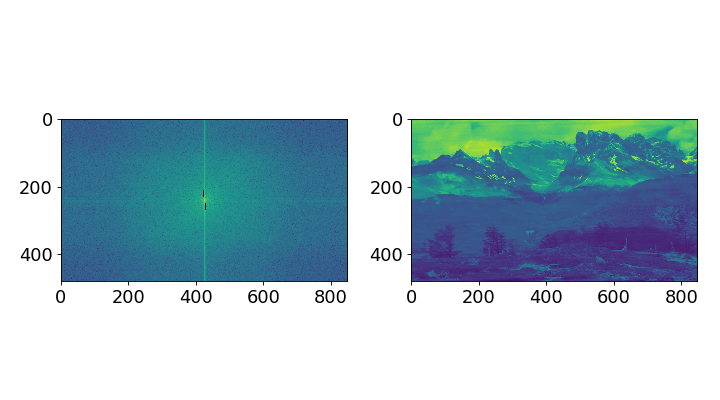

interactive(children=(IntSlider(value=10, description='size', max=20, min=1), Output()), _dom_classes=('widget…

<function __main__.update(size)>

In [8]:
"""
Ajustes del filtro rechaza banda
"""

size = 1
fig, ax = plt.subplots(1, 2, figsize=(9, 5), tight_layout=True)
def update(size):
        img_building = np.array(plt.imread("outfile.jpg"))
        S_img = fftpack.fftshift(fftpack.fft2(img_building))

        S_img[220-size:220+size,421:423] = 0
        S_img[260-size:260+size,425:427] = 0
        #S_img[380-size:380+size,425:427] = 0
        #S_img[440-size:440+size,425:427] = 0
        im = ax[0].imshow(np.log(1+np.abs(S_img)))
        #fig.colorbar(im, ax=ax[0], orientation='horizontal')
        im = ax[1].imshow(np.abs(fftpack.ifft2(fftpack.ifftshift(S_img))))
        #fig.colorbar(im, ax=ax[1], orientation='horizontal')
        

interact(update,size=widgets.IntSlider(min=1, max=20, value=10))

In [10]:
noise_p1 = 220,422
noise_p2 = 260,426

In [11]:
"""
Muestra las imagenes del espectro en secuencia
"""
out = widgets.Image(layout=widgets.Layout(width=str(848), 
                                          height=str(480)))

display(out)

button = widgets.Button(
    description='Play Video',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Replay',
    icon='check'
)

def on_click_button(b):
    for i in tqdm_notebook(range(900)):
        img_building = Image.open("spectres/filtered{0}.jpg".format(i))
        display_frame(out,np.array(img_building).astype(np.uint8))
    

button.on_click(on_click_button)

display(button)


Image(value=b'', layout="Layout(height='480', width='848')")

Button(description='Play Video', icon='check', style=ButtonStyle(), tooltip='Replay')